# Teacher's Pack New Scientist Live 2024 - UCL Institute of Health Informatics

This Jupyter notebook is the code used to wrangle the data and create the visualisations for the New Scientist Live 2024 teacher's pack.

The data used in this notebook is the Fitbit sleep data from the NetHealth project at the University of Notre Dame, USA. Source: https://sites.nd.edu/nethealth/fitbit-data/ 

To download the Fitbit Sleep Data (.csv) data, follow instructions on https://sites.nd.edu/nethealth/data-2/ 

Once downloaded, place the data in the same directory as this notebook, and it is good practice to put the data in a separate data folder.
```
working_dir
├─ data_activity_nethealth_analysis.ipynb
└─ data
   └─ FitbitSleep(1-30-20).csv
```

In Python, the `#` hash symbol is used to comment out code. This means that the code is not run and is only there to provide information.

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

----
## Data Processing

In [2]:
# Load data
data_path = './data'

daily_sleep = pd.read_csv(data_path + '/FitbitSleep(1-30-20).csv')

# Tidy column names
daily_sleep.rename(columns={'dataDate': 'datadate', 'Efficiency':'efficiency'}, inplace=True)

In [3]:
# There are 622 students in the dataset
len(daily_sleep.egoid.unique())

622

In [4]:
# Take a look at the first few rows of the data
daily_sleep.head()

,egoid,datadate,timetobed,timeoutofbed,bedtimedur,minstofallasleep,minsafterwakeup,minsasleep,minsawake,efficiency
0,44869,2015-07-28,06:25:00,10:27:00,243,0,0,232,11,0.954733
1,44869,2015-07-29,03:26:30,07:21:30,236,1,4,216,15,0.935065
2,44869,2015-07-29,12:03:30,16:44:30,282,3,0,267,12,0.956989
3,44869,2015-07-30,06:27:30,14:31:30,485,4,0,451,30,0.937630
4,44869,2015-07-31,04:40:30,06:27:30,108,0,0,100,8,0.925926


In [5]:
# drop incomplete data
daily_sleep.dropna(inplace=True)

# Create new column for day of week
daily_sleep['datadate'] = pd.to_datetime(daily_sleep['datadate'])
daily_sleep['day_of_week'] = daily_sleep['datadate'].dt.day_name()

# Add new column for weekend
# Option 1: Weekend if the sleep began on a Saturday or Sunday
# daily_sleep['weekend'] = daily_sleep['day_of_week'].apply(lambda x: True if x in ['Saturday', 'Sunday'] else False)

# Option 2: Weekend is sleeping on Friday after midday to sleeping on Sunday before midday
daily_sleep['weekend'] = daily_sleep.apply(
    lambda row: 
        (row['day_of_week'] in ['Saturday']) or
        (row['day_of_week'] == 'Friday' and row['timetobed'] >= '12:00') or
        (row['day_of_week'] == 'Sunday' and row['timetobed'] < '12:00'),
    axis=1
)


# Create a new column to extract time of day
daily_sleep['timetobed_hour'] = daily_sleep['timetobed'].apply(lambda x: int(x.split(':')[0]))
daily_sleep['timetobed_minute'] = daily_sleep['timetobed'].apply(lambda x: int(x.split(':')[1]))
daily_sleep['timetobed_second'] = daily_sleep['timetobed'].apply(lambda x: int(x.split(':')[2]))

daily_sleep['timeoutofbed_hour'] = daily_sleep['timeoutofbed'].apply(lambda x: int(x.split(':')[0]))
daily_sleep['timeoutofbed_minute'] = daily_sleep['timeoutofbed'].apply(lambda x: int(x.split(':')[1]))
daily_sleep['timeoutofbed_second'] = daily_sleep['timeoutofbed'].apply(lambda x: int(x.split(':')[2]))


In [6]:
# Take a look at the first few rows of the data after new columns have been added
daily_sleep.head()

,egoid,datadate,timetobed,timeoutofbed,bedtimedur,minstofallasleep,minsafterwakeup,minsasleep,minsawake,efficiency,day_of_week,weekend,timetobed_hour,timetobed_minute,timetobed_second,timeoutofbed_hour,timeoutofbed_minute,timeoutofbed_second
0,44869,2015-07-28,06:25:00,10:27:00,243,0,0,232,11,0.954733,Tuesday,False,6,25,0,10,27,0
1,44869,2015-07-29,03:26:30,07:21:30,236,1,4,216,15,0.935065,Wednesday,False,3,26,30,7,21,30
2,44869,2015-07-29,12:03:30,16:44:30,282,3,0,267,12,0.956989,Wednesday,False,12,3,30,16,44,30
3,44869,2015-07-30,06:27:30,14:31:30,485,4,0,451,30,0.937630,Thursday,False,6,27,30,14,31,30
4,44869,2015-07-31,04:40:30,06:27:30,108,0,0,100,8,0.925926,Friday,False,4,40,30,6,27,30


---------
## Plots

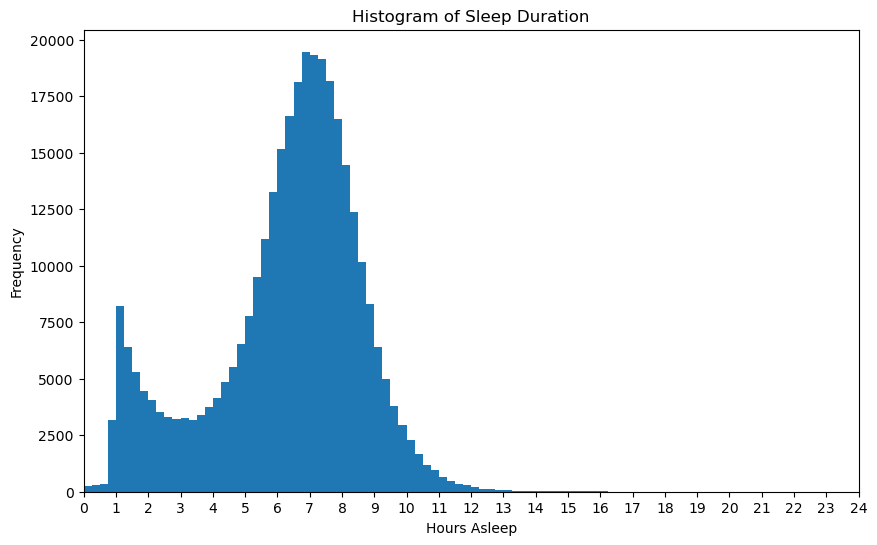

In [7]:
# Make plot of sleep duration of all users
plt.figure(figsize=(10, 6))
plt.hist(daily_sleep['minsasleep']/60, bins=24*4, range=(0, 24))
plt.xlabel('Hours Asleep')
plt.ylabel('Frequency')
plt.xlim([0, 24])

# add ticks for every hours
plt.xticks(np.arange(0, 25, 1))

plt.title('Histogram of Sleep Duration')
plt.show()


# This plot generally shows a normal distribution centered around 7 hours of sleep.
# But more specifically, the distribution is called a bimodal distribution, with two peaks at 1 hour 
# and 7 hours of sleep. 1 hour of sleep is likely naps or returned to bed after waking up.

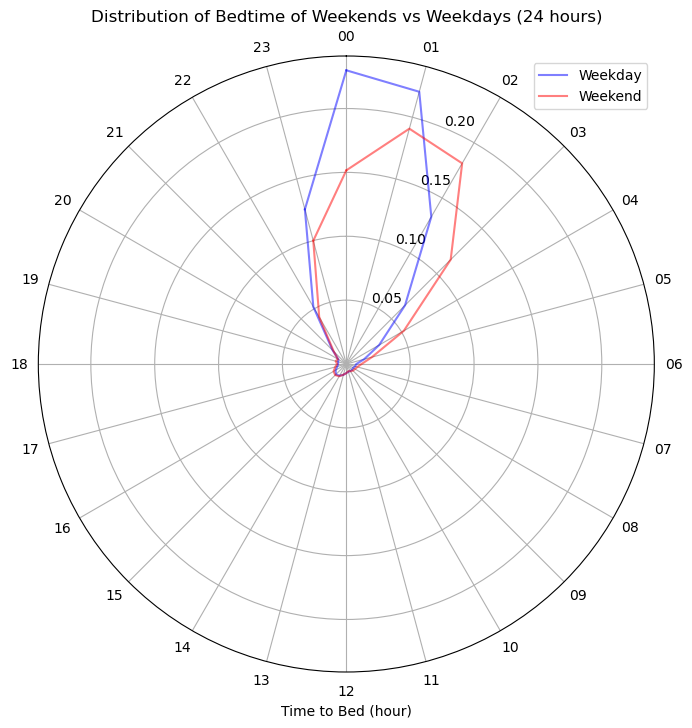

In [8]:
# Plot the distribution of bedtime on weekdays and weekends

# Calculate the percentage of each bedtime hour for weekdays and weekends
plot_df_hist_timetobed_weekend = daily_sleep.groupby(['timetobed_hour', 'weekend']).size().reset_index(name='count')

# Scale the count by total hours per weekend and weekday
plot_df_hist_timetobed_weekend['perc'] = plot_df_hist_timetobed_weekend['count'] / plot_df_hist_timetobed_weekend.groupby('weekend')['count'].transform('sum')


# Create a figure and axes with polar projection
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Prepare the data for 24 hour bins
hours = np.arange(24)
weekday_perc = plot_df_hist_timetobed_weekend[plot_df_hist_timetobed_weekend['weekend'] == False]['perc'].values
weekend_perc = plot_df_hist_timetobed_weekend[plot_df_hist_timetobed_weekend['weekend'] == True]['perc'].values

# Plot the data
ax.plot(np.radians(hours/24*360), weekday_perc, color='blue', alpha=0.5)
ax.plot(np.radians(hours/24*360), weekend_perc, color='red', alpha=0.5)

# complete the circle
ax.plot(np.radians([23/24*360, 0]), [weekday_perc[-1], weekday_perc[0]], color='blue', alpha=0.5)
ax.plot(np.radians([23/24*360, 0]), [weekend_perc[-1], weekend_perc[0]], color='red', alpha=0.5)

# Set the plot title and axis labels
ax.set_title('Distribution of Bedtime of Weekends vs Weekdays (24 hours)')
ax.set_xticks(np.radians(hours/24*360))
ax.set_xticklabels([f"{h:02d}" for h in hours])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xlabel('Time to Bed (hour)')
ax.legend(['Weekday', 'Weekend'])

# Show the plot
plt.show()

# There is a clear difference in the distribution of time to bed between weekday and weekend. 
# On the weekend, people tend to go to bed later than on weekdays, around midnight on weekdays and 
# around 1am to 2am on weekends. There is also greater variability in the time to bed on weekends 
# compared to weekdays.

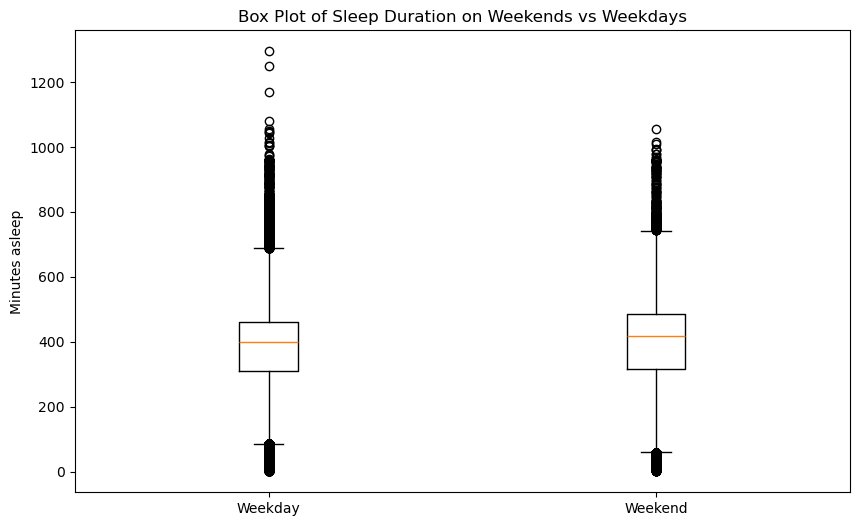

In [9]:
# Box plot of sleep duration on weekend vs weekday
plt.figure(figsize=(10, 6))
plt.boxplot([daily_sleep[daily_sleep['weekend'] == False]['minsasleep'], 
             daily_sleep[daily_sleep['weekend'] == True]['minsasleep']])
plt.ylabel('Minutes asleep')
plt.title('Box Plot of Sleep Duration on Weekends vs Weekdays')
plt.xticks([1, 2], ['Weekday', 'Weekend'])
plt.xlabel('')
plt.show()

# Looking at the median line of the box plot, both the weekend and weekday are between the IQR 
# of the other box plot, suggesting there is no significant difference in sleep duration between 
# weekend and weekday.

Can you think of additional analysis using this data? Perhaps explore how does sleep duration (`minsasleep`) and time in bed (`bedtimedur`) differ, these data are not easy to record manually. You can begin with making a scatter plot of these two variables, what do you see?